In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple
import copy

In [ ]:
MAX_DIST = 2147483647
random.seed(100)

In [ ]:
def calculate_distance(nodes, node1, node2) -> int:
    x1, y1, _ = nodes[node1]
    x2, y2, _ = nodes[node2]
    return round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))

In [ ]:
def create_distance_matrix(nodes) -> np.ndarray:
    matrix = np.zeros(shape=(len(nodes), len(nodes)), dtype=np.int32)
    np.fill_diagonal(matrix, MAX_DIST)
    for node_index_1 in range(len(nodes) - 1):
        for node_index_2 in range(node_index_1 + 1, len(nodes)):
            distance = calculate_distance(nodes, node_index_1, node_index_2)
            matrix[node_index_1, node_index_2] = distance
            matrix[node_index_2, node_index_1] = distance
    return matrix

In [ ]:
def evaluate(distance_matrix: np.ndarray, path: list, costs: list) -> int:
    total_length = 0
    for i in range(len(path) - 1):
        total_length += distance_matrix[path[i], path[i + 1]] + costs[path[i]]
    score = total_length
    return score

In [ ]:
def random_solution(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1
    path = random.sample(list(range(distance_matrix.shape[0])), num_selected)
    path = path + [path[0]]
    return path

In [ ]:
def nearest_neighbor(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = math.ceil(n / 2)

    distance_matrix_copy = distance_matrix.copy()

    current_node_index = start_node

    path = [current_node_index]

    while len(path) < num_selected:

        current_node_distances = distance_matrix_copy[current_node_index, :]

        total_scores = current_node_distances + costs
        closest_node_index = np.argmin(total_scores)

        distance_matrix_copy[current_node_index, :] = MAX_DIST
        distance_matrix_copy[:, current_node_index] = MAX_DIST

        path.append(closest_node_index)
        current_node_index = closest_node_index

    path = path + [path[0]]

    return path

In [ ]:
def greedy_cycle(D, costs, start_node):
    path = [start_node]
    current_node_distances = D[start_node, :]
    total_scores = current_node_distances + costs
    best_neighbour = np.argmin(total_scores)
    path = path + [best_neighbour]
    path = path + [path[0]]

    target_length = math.ceil(len(D) / 2)

    nodes_selected = {start_node, best_neighbour}
    nodes_available = set(list(range(D.shape[0]))) - nodes_selected

    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length + 1:
        best_node = None
        replaced_edge = None
        best_increase = MAX_DIST
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            indices = np.array(list(nodes_available))
            elements = var[indices]
            new_node = indices[np.argmin(elements)]
            curr_increase = var[new_node]
            if curr_increase < best_increase:
                best_increase = curr_increase
                best_node = new_node
                replaced_edge = edge_ix

        path.insert(replaced_edge + 1, best_node)
        nodes_selected.add(best_node)
        nodes_available = nodes_available - nodes_selected
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])
    return path

In [ ]:
# based on your implementation of greedy regret
# 20s runtime for 200 iterations on my system
# performance similar to greedy cycle

def greedy_regret(D, costs, start_node):
    best_neighbour = np.argmin(D[start_node, :] + costs)
    path = [start_node, best_neighbour, start_node]
    target_length = math.ceil(len(D) / 2)
    nodes_available = [x for x in list(range(D.shape[0])) if x not in path]
    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length+1:
        M = np.zeros((len(nodes_available), len(edges)))
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            indices = np.array(nodes_available)
            M[:,edge_ix] = var[indices]

        M_tmp = np.copy(M)
        fc_best_increase = np.min(M_tmp)
        fc_new_node, fc_edge = np.argwhere(M_tmp == fc_best_increase)[0]

        # get second choice smallest value
        M_tmp[fc_new_node, fc_edge] = MAX_DIST
        sc_best_increase = np.min(M_tmp)
        sc_new_node, sc_edge = np.argwhere(M_tmp == sc_best_increase)[0]

        # get first choice regret
        M_tmp[fc_new_node,:] = MAX_DIST
        M_tmp[:,fc_edge] = MAX_DIST
        fc_second_best_increase = np.min(M_tmp)
        fc_regret = fc_best_increase + fc_second_best_increase

        # get second choice regret
        M_tmp[fc_new_node,:] = M[fc_new_node,:]
        M_tmp[:,fc_edge] = M[:,fc_edge]
        M_tmp[sc_new_node,:] = MAX_DIST
        M_tmp[:,sc_edge] = MAX_DIST

        sc_second_best_increase = np.min(M_tmp)
        sc_regret = sc_best_increase + sc_second_best_increase

        if fc_regret < sc_regret:
            replaced_edge = fc_edge
            best_node = nodes_available[fc_new_node]
        else:
            replaced_edge = sc_edge
            best_node = nodes_available[sc_new_node]

        path.insert(replaced_edge + 1, best_node)
        nodes_available.remove(best_node)
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])

    return path

In [ ]:
def greedy_regret_weighted(D, costs, start_node):
    best_neighbour = np.argmin(D[start_node, :] + costs)
    path = [start_node, best_neighbour, start_node]
    target_length = math.ceil(len(D) / 2)
    nodes_available = [x for x in list(range(D.shape[0])) if x not in path]
    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length+1:
        M = np.zeros((len(nodes_available), len(edges)))
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            indices = np.array(nodes_available)
            M[:,edge_ix] = var[indices]

        M_tmp = np.copy(M)
        fc_best_increase = np.min(M_tmp)
        fc_new_node, fc_edge = np.argwhere(M_tmp == fc_best_increase)[0]

        M_tmp[fc_new_node, fc_edge] = MAX_DIST
        sc_best_increase = np.min(M_tmp)
        sc_new_node, sc_edge = np.argwhere(M_tmp == sc_best_increase)[0]

        M_tmp[fc_new_node,:] = MAX_DIST
        M_tmp[:,fc_edge] = MAX_DIST
        fc_second_best_increase = np.min(M_tmp)
        fc_regret = fc_best_increase + fc_second_best_increase

        M_tmp[fc_new_node,:] = M[fc_new_node,:]
        M_tmp[:,fc_edge] = M[:,fc_edge]
        M_tmp[sc_new_node,:] = MAX_DIST
        M_tmp[:,sc_edge] = MAX_DIST

        sc_second_best_increase = np.min(M_tmp)
        sc_regret = sc_best_increase + sc_second_best_increase

        path_score = evaluate(D, path, costs)

        fc_path = path[:]
        fc_path.insert(fc_edge + 1, nodes_available[fc_new_node])
        fc_score = evaluate(D, fc_path, costs)
        fc_weight = 0.5*fc_regret + 0.5*(fc_score-path_score)

        sc_path = path[:]
        sc_path.insert(sc_edge + 1, nodes_available[sc_new_node])
        sc_score = evaluate(D, sc_path, costs)
        sc_weight = 0.5*sc_regret + 0.5*(sc_score-path_score)

        if fc_weight < sc_weight:
            replaced_edge = fc_edge
            best_node = nodes_available[fc_new_node]
        else:
            replaced_edge = sc_edge
            best_node = nodes_available[sc_new_node]

        path.insert(replaced_edge + 1, best_node)
        nodes_available.remove(best_node)
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])

    return path

In [ ]:
def get_plot_values(nodes : Dict[int, Tuple[int, int, int]], solution: List[int], costs: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    x_coords = [nodes[node][0] for node in list(nodes.keys())]
    y_coords = [nodes[node][1] for node in list(nodes.keys())]
    path_x_coords = [nodes[node][0] for node in solution]
    path_y_coords = [nodes[node][1] for node in solution]
    new_costs = [(cost/max(costs))*100 for cost in costs]
    min_cost, max_cost = min(costs), max(costs)
    power = 2
    normalized_costs = [((cost - min_cost) / (max_cost - min_cost)) ** power for cost in costs]
    colors = plt.cm.RdBu(normalized_costs)
    return x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors

In [ ]:
def run_experiment(nodes: Dict[int, Tuple[int, int, int]], distance_matrix: np.ndarray, costs: List[int]) -> None:
  function_mapping = {
      # 'random_algorithm' : random_solution,
      # 'nearest_neighbor' : nearest_neighbor,
      # 'greedy_cycle' : greedy_cycle,
      'greedy_regret' : greedy_regret,
      'greedy_regret_weighted': greedy_regret_weighted
  }

  fig, axes = plt.subplots(1, len(function_mapping), figsize=(15, 5))
  i = 0
  for function_name in list(function_mapping.keys()):
    function = function_mapping[function_name]
    paths = []
    results = []
    for starting_node in range(200):
        path = function(distance_matrix, costs, starting_node)
        score = evaluate(distance_matrix, path, costs)
        paths.append(path)
        results.append(score)

    min_objective = min(results)
    best_solution = paths[np.argmin(results)]
    max_objective = max(results)
    average_objective = sum(results) / len(results)
    print(f'\n{function_name} results:\n')
    print("Max score:", max_objective)
    print("Average score:", average_objective)
    print("Min/Best score:", min_objective)
    print("Selected Nodes:", best_solution)
    x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors = get_plot_values(nodes, best_solution, costs)
    axes[i].scatter(x_coords, y_coords, color=colors, marker='o', s=new_costs, label='Cities')
    axes[i].plot(path_x_coords, path_y_coords, linestyle='-', marker='o', markersize=0, color='blue', label='Path', alpha=0.7)
    axes[i].set_title(f"Best {function_name} solution")
    i += 1


In [ ]:
def get_solution(filename: str) -> None:
  df = pd.read_csv(filename, names=["x", "y", "cost"], sep=';', header=None)
  print(f'Instance: {filename}')
  nodes = {}
  costs = []
  for idx, row in enumerate(df.values):
      x, y, cost = map(int, row)
      costs.append(cost)
      nodes[idx] = (x, y, cost)
  costs = [nodes[node][2] for node in list(nodes.keys())]
  distance_matrix = create_distance_matrix(nodes)
  run_experiment(nodes, distance_matrix, costs)


Instance: TSPA.csv

greedy_regret results:

Max score: 80527
Average score: 77429.26
Min/Best score: 75929
Selected Nodes: [51, 135, 99, 101, 167, 45, 186, 127, 88, 153, 175, 91, 50, 149, 69, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 20, 71, 64, 185, 37, 128, 132, 36, 113, 74, 163, 195, 22, 53, 62, 108, 15, 171, 81, 154, 102, 144, 141, 87, 194, 79, 21, 117, 55, 76, 0, 121, 114, 4, 77, 43, 192, 199, 174, 75, 177, 137, 41, 1, 189, 109, 119, 130, 152, 11, 160, 48, 106, 92, 26, 8, 124, 80, 14, 111, 31, 169, 95, 73, 12, 89, 94, 72, 190, 98, 156, 172, 6, 66, 112, 51]

greedy_regret_weighted results:

Max score: 79318
Average score: 76914.83
Min/Best score: 75680
Selected Nodes: [42, 111, 14, 80, 31, 73, 95, 169, 8, 26, 92, 106, 48, 160, 11, 152, 130, 119, 109, 189, 1, 41, 177, 75, 174, 199, 192, 43, 77, 4, 114, 121, 50, 149, 69, 19, 178, 164, 159, 143, 147, 116, 27, 96, 59, 185, 64, 20, 71, 61, 181, 128, 132, 36, 113, 74, 163, 195, 22, 53, 62, 108, 15, 171, 81, 154, 102, 144, 141, 87, 79

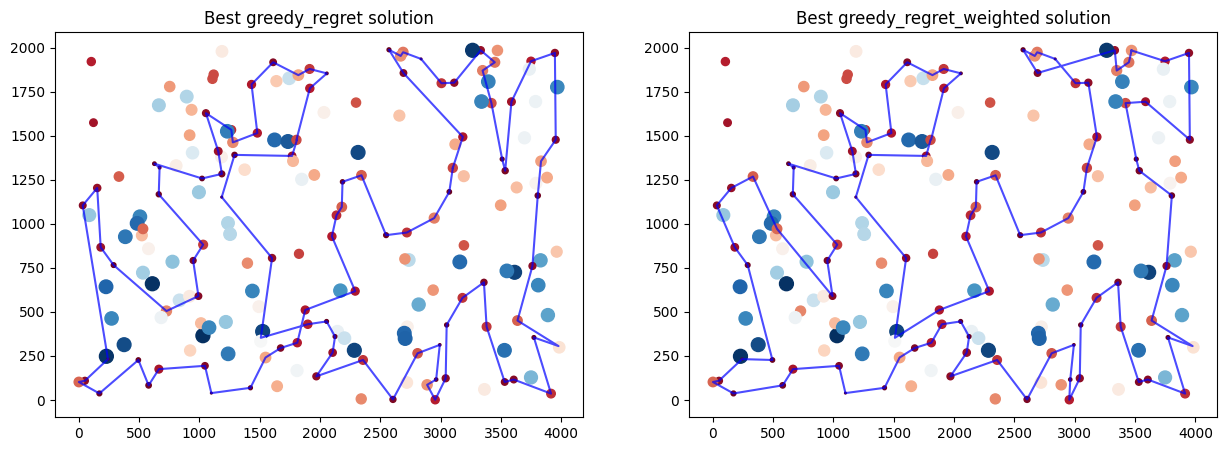

In [ ]:
get_solution('TSPA.csv')

Instance: TSPB.csv

greedy_regret results:

Max score: 75739
Average score: 71199.43
Min/Best score: 69181
Selected Nodes: [33, 29, 19, 190, 198, 135, 145, 157, 80, 153, 4, 55, 88, 154, 134, 25, 36, 165, 37, 137, 57, 0, 99, 50, 127, 24, 121, 131, 103, 38, 101, 31, 92, 122, 143, 179, 197, 183, 34, 5, 128, 66, 169, 95, 172, 16, 18, 132, 52, 14, 8, 115, 82, 63, 53, 141, 148, 140, 70, 91, 51, 174, 130, 142, 21, 192, 196, 117, 150, 158, 67, 114, 72, 85, 171, 58, 89, 129, 159, 147, 64, 166, 162, 44, 71, 119, 59, 193, 139, 97, 107, 12, 109, 189, 181, 170, 185, 73, 61, 136, 33]

greedy_regret_weighted results:

Max score: 76324
Average score: 70758.6
Min/Best score: 68752
Selected Nodes: [29, 33, 136, 61, 73, 185, 170, 181, 189, 12, 107, 97, 139, 193, 59, 119, 71, 44, 162, 166, 64, 147, 159, 129, 89, 58, 171, 72, 85, 114, 67, 158, 150, 117, 196, 192, 21, 142, 130, 174, 51, 91, 70, 140, 148, 141, 53, 82, 115, 63, 8, 14, 52, 132, 18, 16, 172, 95, 169, 66, 128, 5, 34, 183, 197, 179, 143, 122, 92,

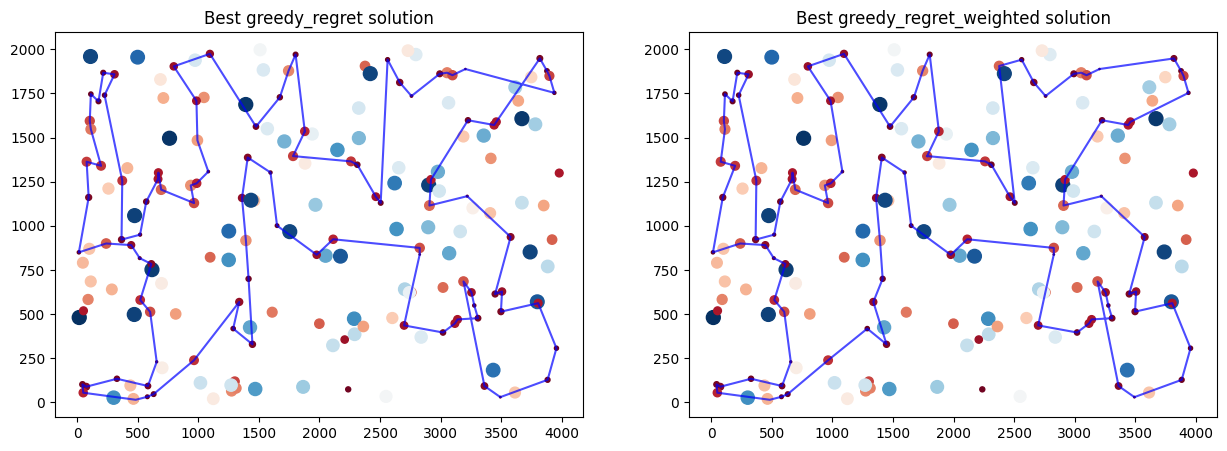

In [ ]:
get_solution('TSPB.csv')

Instance: TSPC.csv

greedy_regret results:

Max score: 58540
Average score: 55821.26
Min/Best score: 53568
Selected Nodes: [35, 19, 178, 164, 34, 40, 128, 132, 36, 55, 195, 22, 18, 53, 62, 180, 32, 154, 133, 81, 108, 15, 117, 171, 194, 79, 21, 157, 170, 186, 45, 127, 88, 153, 161, 76, 145, 49, 0, 115, 69, 149, 50, 121, 91, 114, 175, 167, 101, 60, 126, 99, 135, 196, 51, 5, 112, 190, 66, 6, 172, 156, 98, 72, 94, 42, 89, 12, 73, 31, 95, 169, 110, 8, 26, 106, 198, 48, 92, 134, 119, 130, 109, 189, 75, 1, 177, 41, 137, 174, 39, 199, 150, 192, 29, 2, 4, 77, 43, 86, 35]

greedy_regret_weighted results:

Max score: 59159
Average score: 55995.495
Min/Best score: 54223
Selected Nodes: [8, 105, 123, 124, 80, 107, 14, 111, 197, 31, 73, 12, 89, 42, 94, 72, 98, 156, 172, 6, 66, 190, 112, 5, 51, 45, 186, 127, 88, 153, 161, 76, 0, 49, 145, 55, 117, 15, 171, 157, 21, 194, 79, 87, 141, 144, 102, 133, 154, 81, 108, 180, 32, 93, 62, 53, 18, 22, 195, 138, 74, 163, 113, 25, 181, 61, 71, 20, 64, 185, 85, 36, 

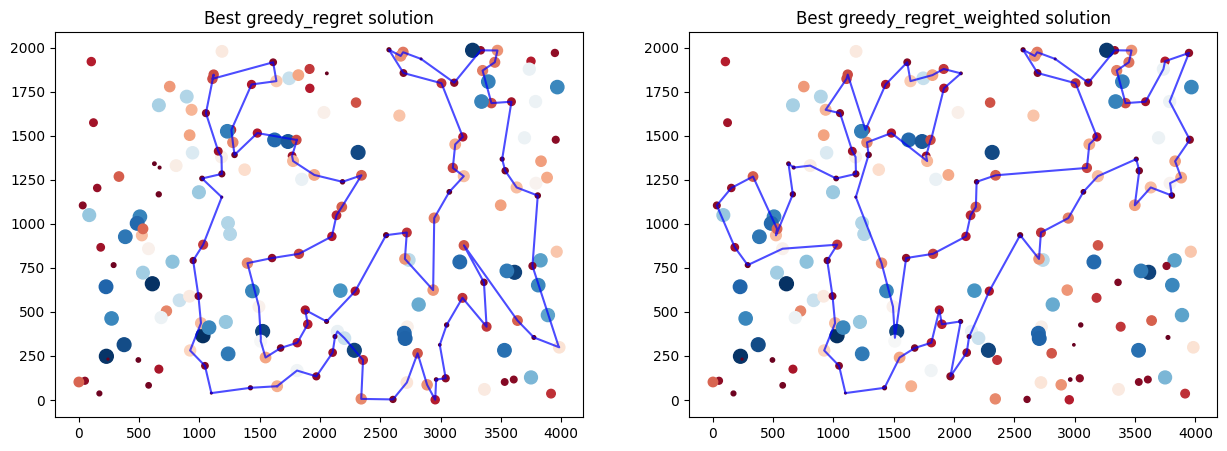

In [ ]:
get_solution('TSPC.csv')

Instance: TSPD.csv

greedy_regret results:

Max score: 60370
Average score: 54593.405
Min/Best score: 48521
Selected Nodes: [132, 12, 107, 97, 59, 119, 193, 71, 44, 162, 158, 126, 45, 67, 114, 72, 85, 171, 58, 89, 129, 159, 147, 64, 28, 166, 110, 150, 117, 192, 142, 130, 141, 188, 140, 148, 161, 174, 70, 91, 51, 156, 3, 78, 155, 21, 196, 139, 52, 65, 18, 16, 8, 172, 95, 163, 182, 2, 133, 167, 5, 34, 183, 197, 179, 143, 121, 24, 127, 122, 92, 26, 128, 66, 169, 0, 99, 102, 37, 165, 137, 88, 55, 4, 153, 145, 157, 80, 57, 135, 198, 190, 19, 168, 29, 33, 136, 61, 73, 185, 132]

greedy_regret_weighted results:

Max score: 60985
Average score: 53551.775
Min/Best score: 50605
Selected Nodes: [161, 188, 140, 148, 141, 130, 13, 142, 53, 149, 96, 32, 113, 69, 82, 115, 40, 63, 8, 14, 16, 18, 29, 168, 172, 95, 163, 182, 2, 5, 34, 197, 183, 179, 143, 121, 24, 127, 122, 92, 26, 128, 66, 169, 135, 198, 190, 19, 6, 33, 136, 61, 73, 81, 185, 132, 65, 52, 12, 107, 97, 139, 84, 138, 21, 192, 60, 196, 117,

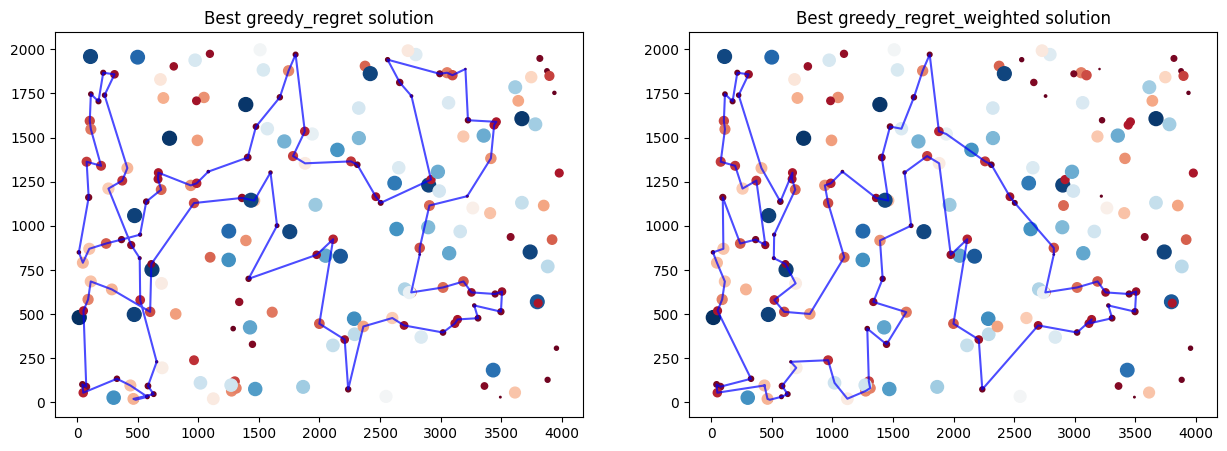

In [ ]:
get_solution('TSPD.csv')